In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace
from flash_ansr.refine import ConvergenceError
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v6.0'

In [3]:
RES = 49
mu_list = np.linspace(-5, 5, RES)
sigma_list = np.linspace(0.1, 25, RES)
N_REPEAT = 5

In [4]:
nsr = FlashANSR(
    expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, 'expression_space.yaml')),
    flash_ansr_transformer=FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL))[1].to(device).eval(),
    n_beams=32,
    n_restarts=8,
    equivalence_pruning=True,
    p0_noise='uniform',
    p0_noise_kwargs={'low': -5, 'high': 5},  # Training prior
)

nsr.flash_ansr_transformer.to(device).eval()


print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

27,137,058 parameters


In [5]:
results = np.zeros((len(mu_list), len(sigma_list), N_REPEAT))
pbar = tqdm(total=results.size)

with torch.no_grad():
    for i, mu in enumerate(mu_list):
        for j, sigma in enumerate(sigma_list):
            for k in range(N_REPEAT):
                demo_expressions = [
                    ('exp(- (x - 1)**2 / 1)', (mu, sigma), (-10, 10)),
                ]

                expression, constants, xlim = demo_expressions[0]

                prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
                prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
                prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
                code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
                code = codify(code_string, nsr.expression_space.variables + constants_names)

                if constants is None:
                    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
                else:
                    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

                x = np.random.uniform(*xlim, 500)

                y = demo_function(x)

                x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
                y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

                pad_length = nsr.flash_ansr_transformer.encoder_max_n_variables - x_tensor.shape[1] - y_tensor.shape[1]
                x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0), value=0)

                try:
                    nsr.fit(x_tensor, y_tensor, converge_error='raise')
                except ConvergenceError:
                    results[i, j, k] = np.nan
                    pbar.update(1)
                    pbar.set_postfix(fvu=np.nan, mu=mu, sigma=sigma, i=i, j=j, k=k)
                    continue

                # results[i, j, k] = nsr.refiner._all_constants_values[0][-1]

                warnings.filterwarnings("ignore", category=RuntimeWarning)
                try:
                    y_pred = nsr.predict(x_tensor.cpu().numpy())
                except (RuntimeError, OverflowError):
                    results[i, j, k] = np.nan
                    pbar.update(1)
                    pbar.set_postfix(fvu=np.nan, mu=mu, sigma=sigma, i=i, j=j, k=k)
                    continue
                
                fvu = np.mean((y_pred[:, 0] - demo_function(x))**2) / np.var(demo_function(x))

                results[i, j, k] = fvu

                pbar.update(1)
                pbar.set_postfix(fvu=fvu, mu=mu, sigma=sigma, i=i, j=j, k=k)

100%|██████████| 12005/12005 [13:20:29<00:00,  4.03s/it, fvu=0.11, i=48, j=48, k=4, mu=5, sigma=25]           

In [5]:
# np.save(get_path('results', 'robustness', 'gaussians', create=True, filename=f'{MODEL}_res-{RES}_rep-{N_REPEAT}.npy'), results)
results = np.load(get_path('results', 'robustness', 'gaussians', filename=f'{MODEL}_res-{RES}_rep-{N_REPEAT}.npy'))

In [6]:
results_median = np.nanmedian(results, axis=-1)

/tmp/ipykernel_1398/469413552.py:1: RuntimeWarning: All-NaN slice encountered
  results_median = np.nanmedian(results, axis=-1)


In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

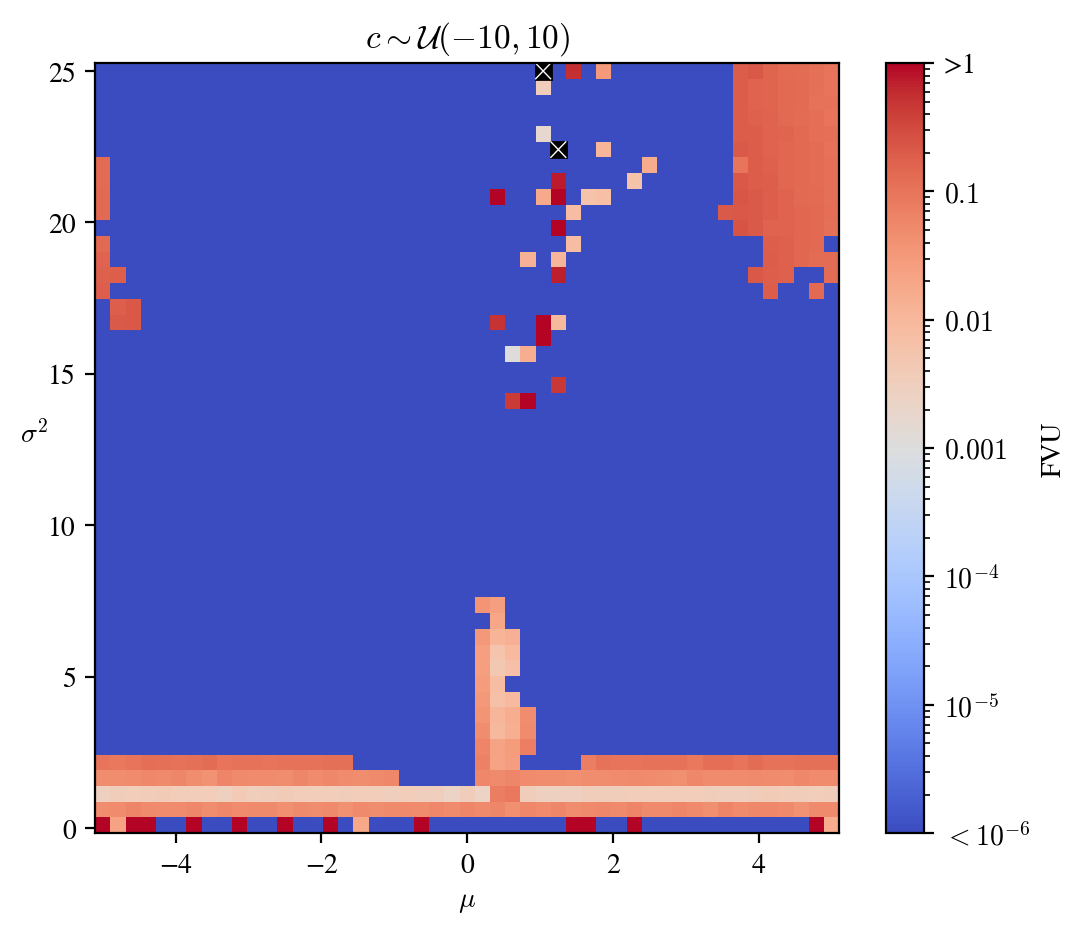

In [12]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
# cax = ax.pcolormesh(mu_list, sigma_list, results_median.T, cmap='coolwarm', vmin=0, vmax=1)
cax = ax.pcolormesh(mu_list, sigma_list, results_median.T, cmap='coolwarm', norm=LogNorm(vmin=1e-6, vmax=1))
colorbar = fig.colorbar(cax, label='FVU')

# Where the result is nan, draw a black square with a white cross
for i, mu in enumerate(mu_list):
    for j, sigma in enumerate(sigma_list):
        if np.isnan(results_median[i, j]):
            # Black square
            ax.add_patch(plt.Rectangle((mu - 0.5 / RES * 10, sigma - 0.5 / RES * 25), 1 / RES * 10, 1 / RES * 25, color='black'))
            # White cross
            ax.plot([mu - 0.5 / RES * 10, mu + 0.5 / RES * 10], [sigma - 0.5 / RES * 25, sigma + 0.5 / RES * 25], color='white', linewidth=0.5)
            ax.plot([mu - 0.5 / RES * 10, mu + 0.5 / RES * 10], [sigma + 0.5 / RES * 25, sigma - 0.5 / RES * 25], color='white', linewidth=0.5)


# Set xticks for the colorbar
colorbar.set_ticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
colorbar.set_ticklabels(['$<10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$0.001$', '$0.01$', '$0.1$', '>1'])


ax.set_title('$c \sim \mathcal{U}(-10, 10)$')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma^2$', rotation=0, labelpad=5);

In [9]:
m = mu_list[24]
s = sigma_list[4]
print(f'mu = {m}, sigma = {s}')

mu = 0.0, sigma = 2.175


In [10]:
demo_expressions = [
    ('exp(- (x - 1)**2 / 1)', (m, s), (-10, 10)),
]

expression, constants, xlim = demo_expressions[0]

prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
code = codify(code_string, nsr.expression_space.variables + constants_names)

if constants is None:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
else:
    demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

x = np.random.uniform(*xlim, 500)

y = demo_function(x)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

pad_length = nsr.nsr_transformer.encoder_max_n_variables - x_tensor.shape[1] - y_tensor.shape[1]
x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0), value=0)

nsr.fit(x_tensor, y_tensor, converge_error='raise')


FlashANSR(expression_space=<flash_ansr.expressions.expression_space.ExpressionSpace object at 0x7f952fdbf5d0>,
          n_beams=32, n_restarts=8,
          nsr_transformer=FlashANSRTransformer(
  (pre_encoder): PreEncoder()
  (encoder): SetTransformer(
    (enc): Sequential(
      (0): ISAB(
        (mab0): MAB(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=64, out_featur...
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=33, bias=True)
  )
  (num_out): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
),
          p0_noise='uniform', p0_noise_kwargs={'high': 5, 'low': -5})

In [11]:
fvu = np.mean((nsr.predict(x_tensor.cpu().numpy())[:, 0] - y)**2) / np.var(y)
print(f'FVU: {fvu:.2e}')

FVU: 1.02e-15


In [12]:
nsr.refiner.transform(nsr._results[0]['expression'])

AttributeError: 'FlashANSR' object has no attribute 'refiner'

In [ ]:
x_linspace = np.linspace(-10.5, 10.5, 1000)

x_linspace_tensor = torch.tensor(x_linspace, dtype=torch.float32).unsqueeze(-1).to(device)
x_linspace_tensor = nn.functional.pad(x_linspace_tensor, (0, pad_length, 0, 0), value=0)

In [ ]:
y_pred_linspace = nsr.predict(x_linspace_tensor.cpu().numpy())

In [ ]:
m, s

(0.10638297872340452, 2.2191489361702126)

Text(0.5, 1.0, '$f(x) = e^{- (x + 3.72)^2 / 2.22}$')

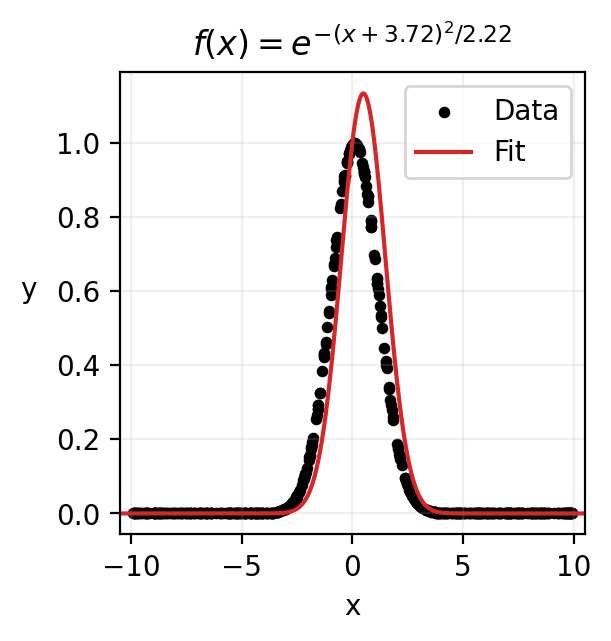

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
ax.scatter(x, y, color='k', label='Data', s=10)
ax.plot(x_linspace, y_pred_linspace, color='tab:red', label='Fit')
ax.grid(alpha=0.2)
ax.set_xlim(-10.5, 10.5)
ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0, labelpad=10)
ax.legend()
ax.set_title('$f(x) = e^{- (x + 3.72)^2 / 2.22}$')

In [ ]:
nsr._results

[{'numeric_prediction': None,
  'beam': [1, 28, 9, 14, 7, 6, 30, 2],
  'expression': ['exp', 'neg', 'pow2', '+', '<num>', 'x1'],
  'lambda': <function nsr.expressions.expression_space.<lambda>(x1, x2, x3, C_0)>,
  'fits': [(array([3.72689362]), array([[0.00024801]]), 0.007891723),
   (array([3.72689365]), array([[0.00024801]]), 0.007891723),
   (array([3.72689085]), array([[0.00024801]]), 0.007891723),
   (array([3.72688993]), array([[0.00024801]]), 0.007891723),
   (array([3.72689079]), array([[0.00024801]]), 0.007891723),
   (array([3.72689208]), array([[0.00024801]]), 0.007891724),
   (array([3.726892]), array([[0.00024801]]), 0.007891724),
   (array([3.72689262]), array([[0.00024801]]), 0.007891724),
   (array([3.72689417]), array([[0.00024801]]), 0.007891724),
   (array([3.7268889]), array([[0.00024801]]), 0.007891724),
   (array([3.7268917]), array([[0.00024801]]), 0.007891724),
   (array([3.72689423]), array([[0.00024801]]), 0.007891724),
   (array([3.72689425]), array([[0.00024